<a href="https://colab.research.google.com/github/riyagoyal17/AI-Mafia-Machine-Learning/blob/main/hiding_1_image_using_original_model_i_e_sse_loss_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data/smalldata1.zip

Streaming output truncated to the last 5000 lines.
  inflating: smalldata1/tacos/101.png  
  inflating: smalldata1/tacos/102.png  
  inflating: smalldata1/tacos/103.png  
  inflating: smalldata1/tacos/104.png  
  inflating: smalldata1/tacos/105.png  
  inflating: smalldata1/tacos/106.png  
  inflating: smalldata1/tacos/107.png  
  inflating: smalldata1/tacos/108.png  
  inflating: smalldata1/tacos/109.png  
  inflating: smalldata1/tacos/11.png  
  inflating: smalldata1/tacos/110.png  
  inflating: smalldata1/tacos/111.png  
  inflating: smalldata1/tacos/112.png  
  inflating: smalldata1/tacos/113.png  
  inflating: smalldata1/tacos/114.png  
  inflating: smalldata1/tacos/115.png  
  inflating: smalldata1/tacos/116.png  
  inflating: smalldata1/tacos/117.png  
  inflating: smalldata1/tacos/118.png  
  inflating: smalldata1/tacos/119.png  
  inflating: smalldata1/tacos/12.png  
  inflating: smalldata1/tacos/120.png  
  inflating: smalldata1/tacos/121.png  
  inflating: smalldata1/tacos/1

In [3]:
!pip install SSIM-PIL

In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model,load_model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from SSIM_PIL import compare_ssim
from PIL import Image
from google.colab import files


In [5]:
#DATA_DIR = "./data"
TRAIN_DIR = "/content/smalldata1"
#TEST_DIR = os.path.join(DATA_DIR, "test")
#print(os.listdir(TRAIN_DIR))
IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=20, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    #print(os.listdir(TRAIN_DIR))
    
    for c in os.listdir("/content/smalldata1"):
        #print(c)
        c_dir = os.path.join("/content/smalldata1",c)
        c_imgs = os.listdir(c_dir)
        #print(c_imgs," ")
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            #print(img_name_i)
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            #img_i = np.asarray(img_i).reshape(64,64)

           # print(img_i.size[0] , img_i.size[1])
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
  
    # Return train and test data as numpy arr
    return np.array(X_train)

In [6]:
# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()
X_train_orig = load_dataset_small()
print(X_train_orig.shape)
# Normalize image vectors.
X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
#print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

(2020, 64, 64, 3)
Number of training examples = 2020
X_train shape: (2020, 64, 64, 3)


In [7]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

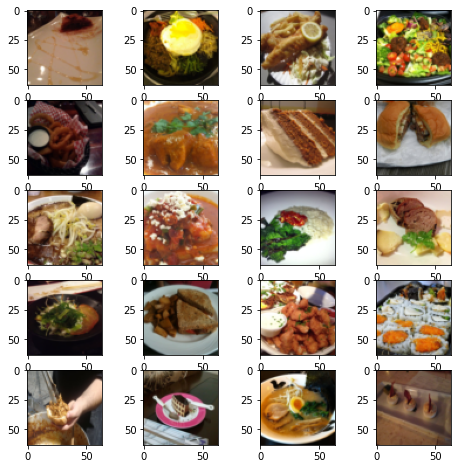

In [8]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [14]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
lc = 1.0
def ssim_loss(y_true, y_pred):
  return  tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    #s_loss = rev_loss(s_true, s_pred)
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = lc * K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [15]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [16]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [17]:
BATCH_SIZE = 32
loss_history = []
rev_history = []
m = input_S.shape[0]
for epoch in range(400):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    
    #autoencoder_model.save_weights('models/model_A_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    rev_history.append(np.mean(rev_loss))

Streaming output truncated to the last 5000 lines.
Epoch 325 | Batch: 224 of 1010. Loss AE    1378.01 | Loss Rev     653.54:  22%|██▏       | 7/32 [00:03<00:11,  2.09it/s]
Epoch 325 | Batch: 224 of 1010. Loss AE    1378.01 | Loss Rev     653.54:  25%|██▌       | 8/32 [00:03<00:11,  2.11it/s]
Epoch 325 | Batch: 256 of 1010. Loss AE    1380.70 | Loss Rev     658.66:  25%|██▌       | 8/32 [00:04<00:11,  2.11it/s]
Epoch 325 | Batch: 256 of 1010. Loss AE    1380.70 | Loss Rev     658.66:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]
Epoch 325 | Batch: 288 of 1010. Loss AE    1348.59 | Loss Rev     645.74:  28%|██▊       | 9/32 [00:04<00:10,  2.10it/s]
Epoch 325 | Batch: 288 of 1010. Loss AE    1348.59 | Loss Rev     645.74:  31%|███▏      | 10/32 [00:04<00:10,  2.11it/s]
Epoch 325 | Batch: 320 of 1010. Loss AE    1316.46 | Loss Rev     629.76:  31%|███▏      | 10/32 [00:05<00:10,  2.11it/s]
Epoch 325 | Batch: 320 of 1010. Loss AE    1316.46 | Loss Rev     629.76:  34%|███▍      | 11/32 [00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

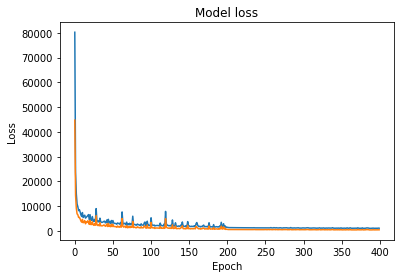

In [18]:
# Plot loss through epochs
plt.plot(loss_history,label = 'overall_loss')
plt.plot(rev_history,label = 'rev_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig("loss.png")
files.download("loss.png") 
plt.show()

In [19]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C) 

In [20]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

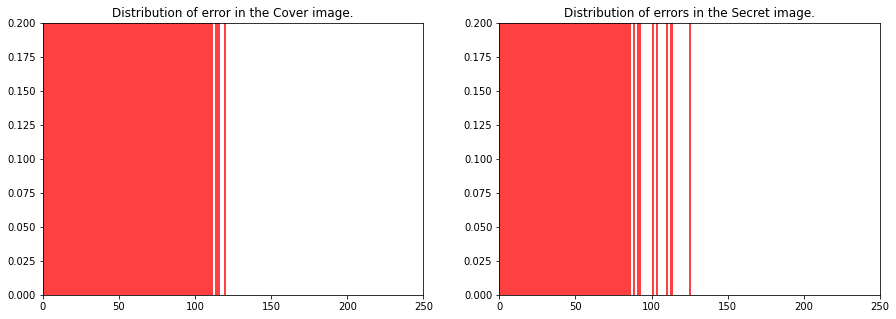

In [21]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

In [22]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 6.560333
C error per pixel [0, 255]: 10.3887825


In [23]:
   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_S, decoded_S, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

secret
ssim1  =  tf.Tensor([0.99997634 0.9999911  0.9999837  ... 0.99997807 0.99998856 0.999975  ], shape=(1010,), dtype=float32)
ssim2 =  tf.Tensor([0.9503501  0.9778207  0.9615982  ... 0.97316605 0.9738953  0.94558877], shape=(1010,), dtype=float32)


In [24]:
   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_C, decoded_C, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_C, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_C, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
print("cover")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

cover
ssim1  =  tf.Tensor([0.9998978  0.99996823 0.9998211  ... 0.9998843  0.99993485 0.9998351 ], shape=(1010,), dtype=float32)
ssim2 =  tf.Tensor([0.948927   0.82003707 0.9696946  ... 0.92477566 0.93805194 0.91449565], shape=(1010,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8899841198057507
No module named 'pyopencl'
secret :  0.909853640740131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8849707557760261
No module named 'pyopencl'
secret :  0.948180006102111
No module named 'pyopencl'
cover :  0.9523808078863261
No module named 'pyopencl'
secret :  0.9733875215550015


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.9147486101331522
No module named 'pyopencl'
secret :  0.9477158150123859
No module named 'pyopencl'
cover :  0.8811645976000083
No module named 'pyopencl'
secret :  0.9479442568755039
No module named 'pyopencl'
cover :  0.9165692148976644
No module named 'pyopencl'
secret :  0.9554002293125406


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

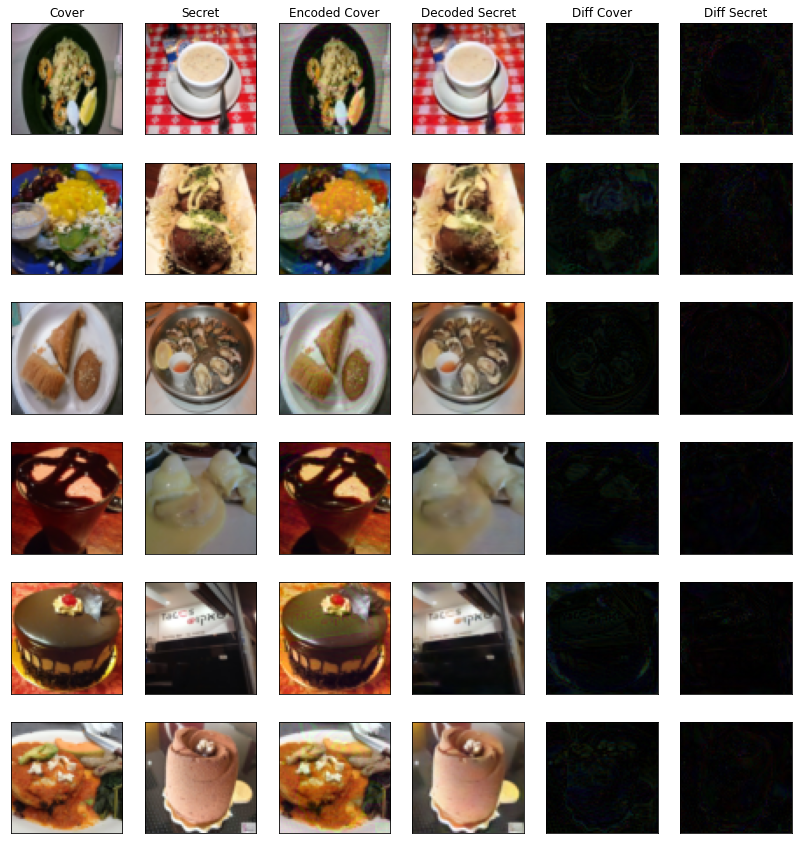

In [25]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
    
    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')

    
    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

    cover = Image.fromarray((input_C[idx] * 255).astype(np.uint8))
    cover_decode = Image.fromarray((decoded_C[idx] * 255).astype(np.uint8))
    valuec = compare_ssim(cover,cover_decode ) # Compare images using OpenCL by default
    print("cover : ",valuec)

    secret = Image.fromarray((input_S[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret : ",values)

plt.savefig("output.png")
files.download("output.png") 
plt.show()

In [26]:
model_json = autoencoder_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder_model.save_weights("models.h5")
print("Saved model to disk")

Saved model to disk
